In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# Base libraries
import os
import random

# Keras libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, Softmax
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

print(tf.__version__)

2.5.0


# 유틸

In [ ]:
def save_model(model_name: str, model: keras.models.Model):
    model_json = model.to_json()
    with open(model_name, "w") as json_file:
        json_file.write(model_json)

from keras.models import model_from_json
from typing import Optional

In [ ]:
def load_model(model_name: str, with_weights_path: Optional[str] = None) -> keras.models.Model:
    json_file = open(model_name, "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    if with_weights_path:
        model.load_weights(with_weights_path)
    return model

In [ ]:
import os
base_gdrive_path = os.path.join("drive", "MyDrive", "deep learning example")

In [ ]:
result_path = os.path.join(base_gdrive_path, "results")

# Dataset

## 다운로드

In [ ]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [ ]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteZJF43K/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


## 살펴보기

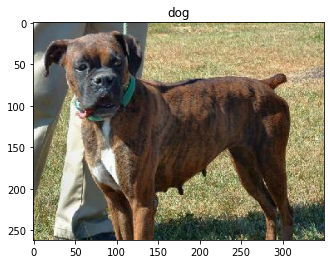

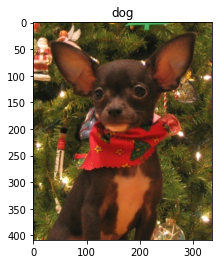

In [ ]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

## 데이터 포맷

In [ ]:
IMG_SIZE = 224 # 모든 이미지는 224x224로 크기가 조정됩니다

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [ ]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [ ]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

## 확인

In [ ]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 224, 224, 3])

In [ ]:
for image_batch, label_batch in train_batches.take(1):
    print(label_batch)

image_batch.shape

tf.Tensor([0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 1 1], shape=(32,), dtype=int64)


TensorShape([32, 224, 224, 3])

# MobileNetV2

## 모델

### 테스트

* https://www.tensorflow.org/tutorials/images/transfer_learning?hl=ko

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# 사전 훈련된 모델 MobileNet V2에서 기본 모델을 생성합니다.
mobile_net_v2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                  include_top=False,
                                                  weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
feature_batch = mobile_net_v2(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [ ]:
mobile_net_v2.trainable = False

In [ ]:
mobile_net_v2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
model = tf.keras.Sequential([
  mobile_net_v2,
  global_average_layer,
  prediction_layer
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
history = model.fit(train_batches,
                    epochs = 10,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 58s 94ms/step - loss: 0.2000 - accuracy: 0.9174 - val_loss: 0.0742 - val_accuracy: 0.9785
Epoch 2/10
582/582 [==============================] - 56s 93ms/step - loss: 0.0584 - accuracy: 0.9834 - val_loss: 0.0516 - val_accuracy: 0.9824
Epoch 3/10
582/582 [==============================] - 56s 93ms/step - loss: 0.0453 - accuracy: 0.9860 - val_loss: 0.0449 - val_accuracy: 0.9845
Epoch 4/10
582/582 [==============================] - 56s 93ms/step - loss: 0.0396 - accuracy: 0.9874 - val_loss: 0.0418 - val_accuracy: 0.9854
Epoch 5/10
582/582 [==============================] - 56s 93ms/step - loss: 0.0364 - accuracy: 0.9879 - val_loss: 0.0400 - val_accuracy: 0.9841
Epoch 6/10
582/582 [==============================] - 55s 92ms/step - loss: 0.0343 - accuracy: 0.9889 - val_loss: 0.0388 - val_accuracy: 0.9858
Epoch 7/10
582/582 [==============================] - 55s 92ms/step - loss: 0.0327 - accuracy: 0.9894 - val_loss: 0.0380 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_batches, verbose=1)

73/73 [==============================] - 5s 67ms/step - loss: 0.0254 - accuracy: 0.9901


In [ ]:
for test_batched_data in test_batches.take(1):
    target = test_batched_data[1].numpy().tolist()

    predicted = model.predict(test_batched_data[0])
    predicted = list(map(lambda in_list: in_list[0], predicted))
    predicted = list(map(lambda value: 1 if value > 0 else 0, predicted))
    
    print("target   : {}".format(target))
    print("predicted: {}".format(predicted))


target   : [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
predicted: [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]


### 모델 생성

아래의 코드를 MobileNet V2에 맞게 작성합니다.

In [ ]:
def mobile_net_v2(size=(224, 224, 3)):
    input = Input(size)
    x = tf.keras.layers.Flatten()(input)
    output = tf.keras.layers.Dense(1)(x)
    model = Model(inputs=[input], outputs=[output])
    return model

In [ ]:
project_model = mobile_net_v2()
project_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      metrics=['accuracy'])
project_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 150529    
Total params: 150,529
Trainable params: 150,529
Non-trainable params: 0
_________________________________________________________________


### 모델 트레이닝

In [ ]:
project_history = project_model.fit(train_batches,
                                    epochs = 10,
                                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 43s 69ms/step - loss: 0.9639 - accuracy: 0.5469 - val_loss: 0.8622 - val_accuracy: 0.5692
Epoch 2/10
582/582 [==============================] - 42s 69ms/step - loss: 0.9003 - accuracy: 0.5819 - val_loss: 0.8398 - val_accuracy: 0.5572
Epoch 3/10
582/582 [==============================] - 42s 69ms/step - loss: 0.8817 - accuracy: 0.5895 - val_loss: 1.0175 - val_accuracy: 0.5374
Epoch 4/10
582/582 [==============================] - 41s 68ms/step - loss: 0.8541 - accuracy: 0.6075 - val_loss: 0.8441 - val_accuracy: 0.5830
Epoch 5/10
582/582 [==============================] - 41s 68ms/step - loss: 0.8300 - accuracy: 0.6183 - val_loss: 0.9152 - val_accuracy: 0.5881
Epoch 6/10
582/582 [==============================] - 41s 67ms/step - loss: 0.8242 - accuracy: 0.6254 - val_loss: 0.9392 - val_accuracy: 0.5705
Epoch 7/10
582/582 [==============================] - 41s 67ms/step - loss: 0.8031 - accuracy: 0.6336 - val_loss: 1.4107 - val_accuracy:

[0.5468565225601196, 0.5819451808929443, 0.5894680023193359, 0.6075228452682495, 0.6182697415351868, 0.6254164576530457, 0.6336378455162048, 0.6391187310218811, 0.6471789479255676, 0.6578183770179749]
[0.5692175626754761, 0.5571796894073486, 0.5374032855033875, 0.5829750895500183, 0.5881341099739075, 0.570507287979126, 0.5511608123779297, 0.5541702508926392, 0.5920034646987915, 0.5640584826469421]


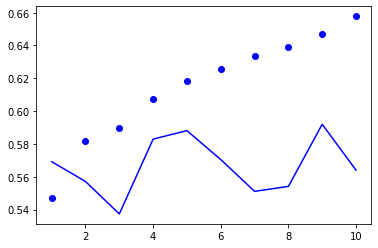

In [ ]:
history_accuracy = project_history.history["accuracy"]
history_val_accuracy = project_history.history["val_accuracy"]

epochs = range(1, len(history_accuracy) + 1)
plt.plot(epochs, history_accuracy, "bo", label="Training accuracy")
plt.plot(epochs, history_val_accuracy, "b", label="Validation accuracy")

print(history_accuracy)
print(history_val_accuracy)

[0.9639055728912354, 0.9003187417984009, 0.8817076683044434, 0.8540953993797302, 0.8299671411514282, 0.8242315649986267, 0.8031350374221802, 0.7916036248207092, 0.7734927535057068, 0.7498893141746521]
[0.8621550798416138, 0.8397683501243591, 1.0174530744552612, 0.8441222310066223, 0.9152256846427917, 0.939166247844696, 1.4106833934783936, 1.1253820657730103, 0.8428621292114258, 1.068973183631897]


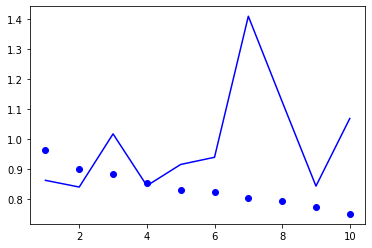

In [ ]:
history_loss = project_history.history["loss"]
history_val_loss = project_history.history["val_loss"]

epochs = range(1, len(history_loss) + 1)
plt.plot(epochs, history_loss, "bo", label="Training loss")
plt.plot(epochs, history_val_loss, "b", label="Validation loss")

print(history_loss)
print(history_val_loss)

### 모델 테스트 및 예측

In [ ]:
project_test_loss, project_test_acc = project_model.evaluate(test_batches, verbose=1)

73/73 [==============================] - 4s 58ms/step - loss: 1.0851 - accuracy: 0.5696


In [ ]:
for test_batched_data in test_batches.take(1):
    target = test_batched_data[1].numpy().tolist()

    predicted = project_model.predict(test_batched_data[0])
    predicted = list(map(lambda in_list: in_list[0], predicted))
    predicted = list(map(lambda value: 1 if value > 0 else 0, predicted))
    
    print("target   : {}".format(target))
    print("predicted: {}".format(predicted))


target   : [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
predicted: [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
